In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from random import randint
from tqdm import tqdm, trange
from numpy.lib.stride_tricks import as_strided
import time

In [2]:
img = plt.imread("base.jpg")
FINAL_SIZE = (1500, 1500)
PATCH_SIZE = (300, 300)
OVERLAP = 10
print(img.shape)

def template_match_ssd_with_mask(img, temp, mask):
    sums = []
    sum_num = 0
    minim = 1000000000
    minim_pos = (0, 0)
    res = np.zeros((img.shape[0] - temp.shape[0] + 1, img.shape[1] - temp.shape[1] + 1))
    for i in range(img.shape[0] - temp.shape[0] + 1):
        for j in range(img.shape[1] - temp.shape[1] + 1):
            sq = np.square(img[i:i+temp.shape[0], j:j+temp.shape[1]] - temp)
            cost = np.sum(np.multiply(sq, mask))
            res[i][j] = cost
            if i == 0 and j == 0:
                minim = cost
            else:
                if cost < minim:
                    minim = cost
                    minim_pos = (i, j)
    return res, minim_pos

def template_match_ssd(img, temp):
    res = np.zeros((img.shape[0] - temp.shape[0] + 1, img.shape[1] - temp.shape[1] + 1))
    for i in range(img.shape[0] - temp.shape[0] + 1):
        for j in range(img.shape[1] - temp.shape[1] + 1):
            cost = np.sum(np.square(img[i:i+temp.shape[0], j:j+temp.shape[1]] - temp))
            res[i][j] = cost
    return res

def template_match_ssd_fast(img, temp):
    y = as_strided(img, shape=(img.shape[0] - temp.shape[0] + 1, img.shape[1] - temp.shape[1] + 1,) + temp.shape, strides=img.strides * 2)
    ssd = np.einsum('ijkl,kl->ij', y, temp)
    ssd = np.int16(ssd)
    ssd *= -2
    ssd += np.einsum('ijkl, ijkl->ij', y, y)
    ssd += np.einsum('ij, ij', temp, temp)
    return ssd

def convert_3to1(img):
    if len(img.shape) > 2 and img.shape[2] > 1:
        r,g,b = cv.split(img)
        return r+g+b
    else:
        return img
    
def get_random_patch(img, PATCH_SIZE):
    i = randint(0, img.shape[0] - PATCH_SIZE[0])
    j = randint(0, img.shape[1] - PATCH_SIZE[1])
    return img[i : i + PATCH_SIZE[0], j : j + PATCH_SIZE[1]]

def get_best_patch(img, temp, mask):
    res, ind = template_match_ssd_with_mask(img, temp, mask)
#     ind = np.argwhere(res == np.min(res))[0]
    return img[ind[0]:ind[0]+temp.shape[0], ind[1]:ind[1]+temp.shape[1]]

a = np.array([[0, 0, 0, 0 , 0], [0, 0, 1, 1, 0], [0, 0 ,1, 1, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], dtype=np.uint8)
b = np.array([[1, 1], [1, 0]], dtype=np.uint8)
t = time.time()
print(template_match_ssd(a, b))
print(time.time() - t)
t = time.time()
print(template_match_ssd_fast(a, b))
print(time.time() - t)
print(get_best_patch(a, b, np.ones_like(b)))

(400, 400, 3)
[[3. 4. 3. 2.]
 [3. 3. 1. 1.]
 [3. 2. 1. 2.]
 [3. 3. 3. 3.]]
0.03212428092956543
[[3 4 3 2]
 [3 3 1 1]
 [3 2 1 2]
 [3 3 3 3]]
0.0014805793762207031
[[1 1]
 [1 1]]


100%|██████████| 6/6 [00:16<00:00,  2.77s/it]


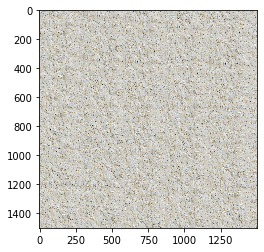

In [4]:
img_final = np.zeros((FINAL_SIZE[0], FINAL_SIZE[1], 3), dtype=np.uint8)

one_mask = np.ones(PATCH_SIZE)
left_mask = np.zeros(PATCH_SIZE)
top_mask = np.zeros(PATCH_SIZE)
top_left_mask = np.zeros(PATCH_SIZE)
left_mask[:, :OVERLAP] = 1
top_mask[:OVERLAP, :] = 1
top_left_mask[:, :OVERLAP] = 1
top_left_mask[:OVERLAP, :] = 1

for i in range(0, FINAL_SIZE[0], PATCH_SIZE[0] - OVERLAP):
    for j in trange(0, FINAL_SIZE[1], PATCH_SIZE[1] - OVERLAP):
        patch = img_final[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
        if patch.shape != one_mask.shape:
            one_mask = np.ones_like(patch)
            left_mask = np.zeros_like(patch)
            top_mask = np.zeros_like(patch)
            top_left_mask = np.zeros_like(patch)
            left_mask[:, :OVERLAP] = 1
            top_mask[:OVERLAP, :] = 1
            top_left_mask[:, :OVERLAP] = 1
            top_left_mask[:OVERLAP, :] = 1
        if i == 0:
            if j == 0:
                res = get_random_patch(img, PATCH_SIZE)
            else:
                res = np.multiply(patch, left_mask/2) +  np.multiply((one_mask - left_mask/2), get_best_patch(img, patch, left_mask))
        else:
            if j == 0:
                res = np.multiply(patch, top_mask/2) +  np.multiply((one_mask - top_mask/2), get_best_patch(img, patch, top_mask))
            else:
                res = np.multiply(patch, top_left_mask/2) +  np.multiply((one_mask - top_left_mask/2), get_best_patch(img, patch, top_left_mask))
        img_final[i : i + PATCH_SIZE[0], j : j + PATCH_SIZE[1]] = res
        

plt.imshow(img_final)
plt.imsave("im2.jpg", img_final)

<div dir="rtl">
طبق گفته سوال، کاشی ها را اینبار با یکممی هم پوشانی چسباندیم و نقاط همپوشانی را میانگین گرفتیم. در پیاده سازی تابع پیدا کردن بهترین پچ، یک ورودی به اسم ماسک هم می گیریم که در اصل تایین می کند کدام خانه های تمپلیت مهم هستند و باقی را صفر می کند که کمک می کند تا ارور قسمت های دلخواه را بدست آوریم
</div>


